# Intelligent Systems 3: Probabilistic and Deep Learning
#### Exam number:

In [952]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, ElasticNetCV
from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, SplineTransformer
import seaborn as sn
import torch
import torch.nn as nn
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from skimage import io,transform
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage, RandomCrop

In [953]:
def plot_model(model, x_test, y_test):
    prediction = model.predict(x_test)
    true_value = y_test.iloc[0]
    predicted_value = prediction[0]
    print(f"Next True value: {true_value} Next predicted value: {predicted_value} Relative Error: {abs((predicted_value-true_value)/true_value)*100}%")
    plt.figure(figsize=(10,5))
    plt.scatter(target.index, target)
    plt.plot(target.index, target, color="black")
    plt.scatter(y_test.index,prediction, color="green")
    plt.show()


# 1 Using Regression

## Data Exploration

#### Plotted Data

In [973]:
df = pd.read_csv("data.csv")

In [976]:
df

,A_Lag_0,B_Lag_0,C_Lag_0,D_Lag_0
1,10.00,2.20,3.0,0.8
2,9.95,2.21,3.0,0.7
3,9.93,2.30,2.5,0.9
4,9.88,2.30,2.5,1.1
5,9.84,2.31,2.5,0.9
...,...,...,...,...
223,8.98,3.00,0.0,1.3
224,8.91,3.10,0.0,1.5
225,8.80,3.20,0.0,1.6
226,8.73,3.10,0.0,1.4


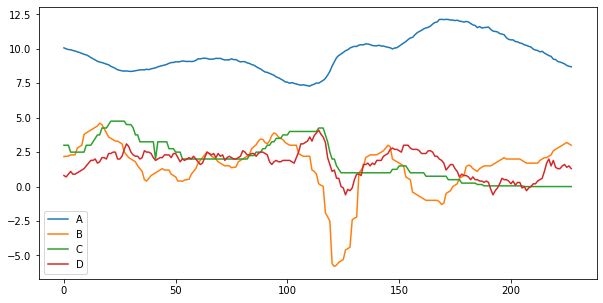

In [950]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df)
plt.legend(df.columns)
plt.show()

From plotting the data its quite east to see that there is a visible correlation between B, C and D.

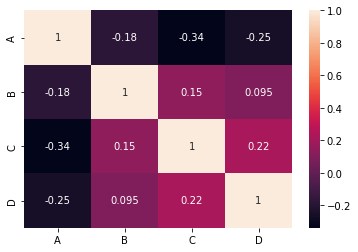

In [957]:
corrMatrix = df.diff().corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there is a relatively strong correlation between D and C but besides that there do not appear to be strongly correlated features

## Basic Regression
This is regression applied to the variables A, B, C and D(Time Lagged)

In [978]:
def preprocess_data(location,time_lag):
    df = pd.read_csv(location)
    target = df["D"].copy()
    df["D"] = target.shift(1)
    for index, columns in enumerate(["A", "B", "C", "D"]):
        for i in range(time_lag+1):
            df[f"{columns}_Lag_{i}"] = df[columns].shift(i)
    df = df.dropna()
    df.drop(["A","B","C","D"],axis=1,inplace=True)
    target = target.iloc[time_lag+1:]

    return df,target

In [979]:
df , target = preprocess_data("data.csv",0)

In [980]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=24)

In [981]:
model = LinearRegression()

In [982]:
model.fit(x_train,y_train)

LinearRegression()

In [983]:
r2_score(y_test, model.predict(x_test))

0.8490850544275201

In [984]:
model.coef_

array([-0.01464466,  0.03385414,  0.00246456,  0.94113835])

Next True value: 0.3 Next predicted value: 0.39306955049345704 Relative Error: 31.02318349781902%


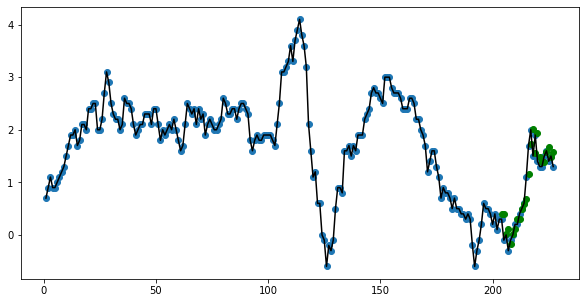

In [985]:
plot_model(model,x_test,y_test)

### Time Laggged Linear Regression

In [932]:
df, target = preprocess_data("data.csv",4)

The code cell below adds time lag to the dataset. By default the shift function deletes data, but there are options to fill the deleted data wih any given value. At first I attempted to duplicate the first know value but this did not improve accuracy.

Data is split into a 2 sets, the training set and the testing set

In [933]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=24)

In [934]:
model = LinearRegression()

In [935]:
model.fit(x_train,y_train)

LinearRegression()

In [936]:
r2_score(y_test, model.predict(x_test))

0.8499773374753242

Next True value: 0.3 Next predicted value: 0.30346418426798866 Relative Error: 1.1547280893295562%


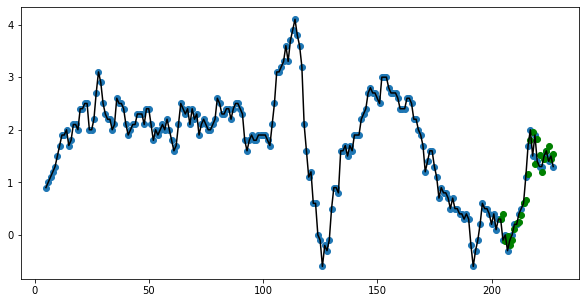

In [938]:
plot_model(model,x_test,y_test)

### Regularisation

Regularisation is the process of adding a penalty function to model. In the real world its very rare that data exists with no noise, so regularisation is a tool that can be used to decrease the likelyhood of the model overfitting and therefore generalising better


In [939]:
df, target = preprocess_data("data.csv",0)

In [940]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=25)

In [941]:
myalphas = np.logspace(-6, 6, 13)

#### Ridge Regression
Ridge Regression is most effective when the features are highly correlated.

In [942]:
model = RidgeCV()

In [943]:
ridge_reg = model.fit(x_train,y_train)

In [944]:
r2_score(y_test, ridge_reg.predict(x_test))

0.8528251571656396

Next True value: 0.3 Next predicted value: 0.20060867323437406 Relative Error: 33.13044225520864%


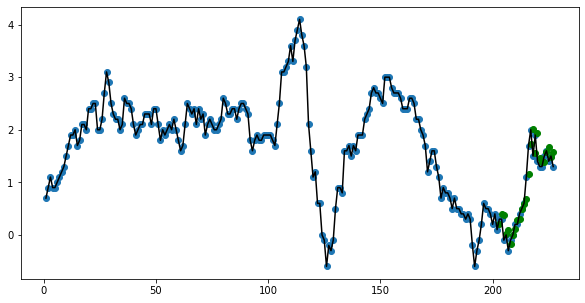

In [945]:
plot_model(ridge_reg,x_test,y_test)

#### Lasso Regression

In [877]:
model = LassoCV(alphas=myalphas)

In [878]:
lasso_reg = model.fit(x_train,y_train)

In [879]:
r2_score(y_test, lasso_reg.predict(x_test))

0.8536675982744497

Next True value: 0.3 Next predicted value: 0.21511301087083892 Relative Error: 28.295663043053693%


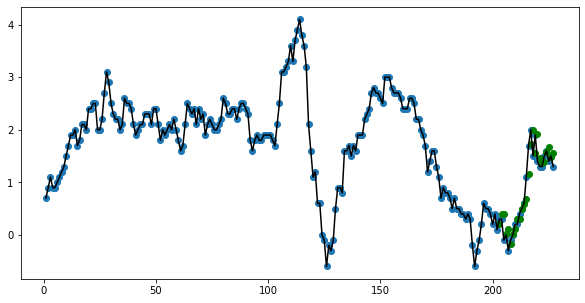

In [880]:
plot_model(lasso_reg,x_test,y_test)

#### Elastic Net Regression

In [885]:
model = ElasticNetCV()

In [886]:
elastic_reg = model.fit(x_train, y_train)

In [887]:
r2_score(y_test, elastic_reg.predict(x_test))

0.8533406280317131

Next True value: 0.3 Next predicted value: 0.2067323008920996 Relative Error: 31.0892330359668%


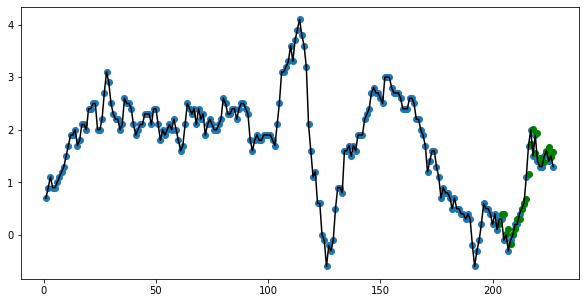

In [888]:
plot_model(elastic_reg, x_test, y_test)

## Polynomial Regression

In [890]:
df, target = preprocess_data("data.csv",0)

In [891]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=60)

In [892]:
model = make_pipeline(PolynomialFeatures(3),RidgeCV())

In [893]:
poly_regression = model.fit(x_train, y_train)

In [894]:
r2_score(y_test, poly_regression.predict(x_test))

0.7175258293659955

Next True value: 2.0 Next predicted value: 2.2480660261983387 Relative Error: 12.403301309916937%


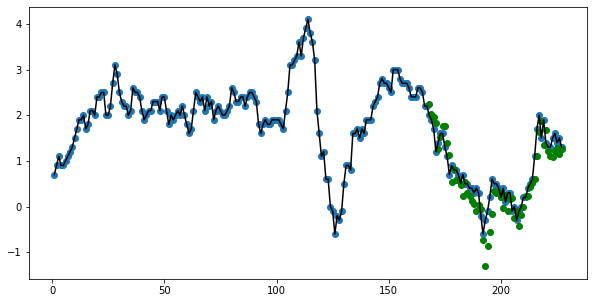

In [895]:
plot_model(poly_regression,x_test,y_test)

## Piecewise Regression

In [896]:
df, target = preprocess_data("data.csv",0)

In [897]:
x_train, x_test, y_train, y_test = train_test_split(df.tail(100),target.tail(100),shuffle=False,test_size=10)

In [898]:
ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

In [899]:
def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0]

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution)
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution

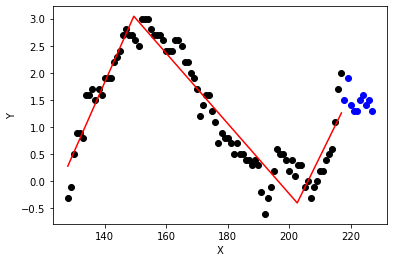

In [900]:
plt.plot( x_train.index, y_train, 'ok' );
plt.scatter(y_test.index, y_test,color="blue")
initialBreakpoints = [140,200]
#Try also with 3 breakpoints, e.g. [3,5,6]
model_prediction = SegmentedLinearReg( x_train.index, y_train, initialBreakpoints )
plt.plot( *model_prediction, '-r' );
plt.xlabel('X'); plt.ylabel('Y');

## Spline Interpolation

In [901]:
df , target = preprocess_data("data.csv",0)

In [902]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=40)

In [903]:
spline_model = make_pipeline(SplineTransformer(n_knots=3,degree=3),LinearRegression())

In [904]:
spline_model.fit(x_train,y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=3)),
                ('linearregression', LinearRegression())])

In [905]:
r2_score(y_test, spline_model.predict(x_test))

0.762748043252482

Next True value: 0.3 Next predicted value: 0.424072265625 Relative Error: 41.35742187500001%


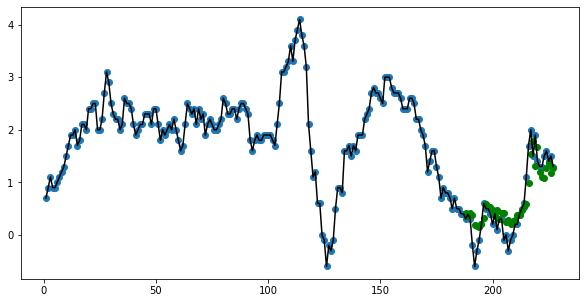

In [906]:
plot_model(spline_model,x_test, y_test)

## Final Solution - Test Data Demonstration

For my final soloution, I am attempting to combine the most effective techniques (in terms of r_2)

In [958]:
myalphas = np.logspace(-6, 6, 13)

In [959]:
df,target = preprocess_data("data.csv",4)

In [960]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df = pd.DataFrame(scaled, columns=df.columns)

In [961]:
df

,A_Lag_0,A_Lag_1,A_Lag_2,A_Lag_3,A_Lag_4,B_Lag_0,B_Lag_1,B_Lag_2,B_Lag_3,B_Lag_4,C_Lag_0,C_Lag_1,C_Lag_2,C_Lag_3,C_Lag_4,D_Lag_0,D_Lag_1,D_Lag_2,D_Lag_3,D_Lag_4
0,0.191786,0.219065,0.254117,0.265907,0.301316,0.459978,0.456923,0.459330,0.415926,0.413405,0.425665,0.419415,0.413152,0.747967,0.740693,-0.883562,-0.670015,-0.877260,-1.080784,-0.970532
1,0.145002,0.187845,0.215057,0.250271,0.262209,0.711627,0.462064,0.459330,0.462322,0.418567,0.425665,0.419415,0.413152,0.404976,0.740693,-0.883562,-0.880901,-0.666680,-0.870750,-1.075340
2,0.106015,0.141015,0.183809,0.211183,0.246566,0.762984,0.713971,0.464477,0.462322,0.465026,0.425665,0.419415,0.413152,0.404976,0.396794,-0.778027,-0.880901,-0.877260,-0.660715,-0.865724
3,0.059232,0.101990,0.136937,0.179912,0.207459,0.814341,0.765381,0.716693,0.467477,0.465026,0.425665,0.419415,0.413152,0.404976,0.396794,-0.672491,-0.775458,-0.877260,-0.870750,-0.656108
4,0.004650,0.055160,0.097877,0.133006,0.176174,1.214925,0.816790,0.768165,0.720080,0.470188,0.425665,0.419415,0.413152,0.404976,0.396794,-0.566956,-0.670015,-0.771970,-0.870750,-0.865724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,-0.478783,-0.436556,-0.409901,-0.304785,-0.285287,0.814341,0.765381,0.716693,0.668528,0.619888,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.461421,-0.459128,-0.350810,0.179424,-0.236876
219,-0.533364,-0.483386,-0.441149,-0.414233,-0.308751,0.865698,0.816790,0.768165,0.720080,0.671509,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.250350,-0.459128,-0.456100,-0.345663,0.182357
220,-0.619134,-0.538021,-0.488021,-0.445503,-0.418251,0.917055,0.868200,0.819638,0.771631,0.723129,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.144815,-0.248241,-0.456100,-0.450680,-0.341684
221,-0.673715,-0.623876,-0.542705,-0.492410,-0.449536,0.865698,0.919609,0.871111,0.823182,0.774750,-1.273643,-1.285461,-1.297446,-1.309980,-1.322699,-0.355886,-0.142798,-0.245520,-0.450680,-0.446492


In [967]:
x_train, x_test, y_train, y_test = train_test_split(df,target,shuffle=False,test_size=24)

In [968]:
model = make_pipeline(RidgeCV())

In [969]:
model.fit(x_train,y_train)

Pipeline(steps=[('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [970]:
r2_score(y_test, model.predict(x_test))

0.8556494922440703

Next True value: 0.3 Next predicted value: 0.3072181851482092 Relative Error: 2.406061716069737%


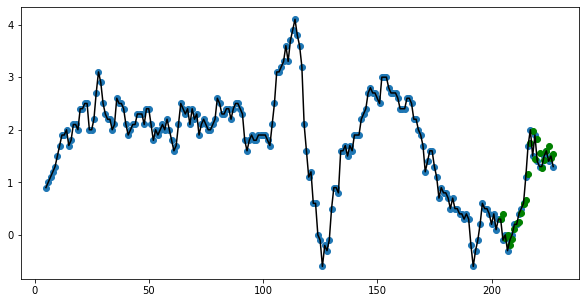

In [971]:
plot_model(model,x_test,y_test)

## Final Solution - Markers Evaluation

Here is my final solution to be executed with the unseen data set, I am assuming the dataset is a csv file in the same directory as this notebook

In [917]:
df = pd.read_csv("unseen.csv")
df["target"] = df["D"].copy()
df["D"] = df["D"].shift(1)
for index, columns in enumerate(["A", "B", "C", "D"]):
    for i in range(4):
        fill_value = df[columns].iloc[0]
        df[f"{columns}_Lag_{i}"] = df[columns].shift(i)
df.drop(["A", "B", "C", "D"], axis=1, inplace=True)
df = df.dropna()
target = df["target"]
df.drop(["target"], axis=1, inplace=True)
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df = pd.DataFrame(scaled, columns=df.columns)
print(f" R_2 score: {r2_score(target, model.predict(df))}")
plot_model(model,df,target)

C:\Users\Skwix\anaconda3\envs\int\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- A_Lag_4
- B_Lag_4
- C_Lag_4
- D_Lag_4

  warnings.warn(message, FutureWarning)


ValueError: X has 16 features, but SplineTransformer is expecting 20 features as input.

In the plot above, the green points are generated by my model, where are the blue points represent the data in unseen.csv

# 2. Descriptive statistics and dimensionality reduction

In [497]:
pca = PCA(n_components=12,svd_solver = 'full')

In [498]:
pca.fit(df)

PCA(n_components=12, svd_solver='full')

In [499]:
pca_df = pd.DataFrame(pca.fit_transform(df))

In [500]:
df.var(axis=0).sort_values(ascending=False)

B_Lag_0      3.739286e+00
B_Lag_49     3.732974e+00
B_Lag_48     3.732835e+00
B_Lag_50     3.732389e+00
B_Lag_51     3.730975e+00
                 ...     
D_Lag_227    3.577893e-30
A_Lag_227    3.169344e-30
C_Lag_225    0.000000e+00
C_Lag_226    0.000000e+00
C_Lag_227    0.000000e+00
Length: 912, dtype: float64

In [501]:
print(f"Total Variance for normal data: {pd.Series(df.var(axis=0)).sum()}")

Total Variance for normal data: 858.6203648832986


In [502]:
print(f"Total Variance for PCA data: {pca_df.var(axis=0).sum()}")

Total Variance for PCA data: 816.107530042386


## 1.2 PCA Calulation

### Steps
1. Centre Matrix
2. Calculate the covariance matrix
3. Calculate eigenvectors & eigenvalues of the covariance matrix
4. Select the first n eigenvectors


In [504]:
mean_df = np.mean(df.T,axis=1)

In [505]:
centre =df - mean_df

In [506]:
covariance = np.cov(df.T)

In [507]:
centre

,A_Lag_0,A_Lag_1,A_Lag_2,A_Lag_3,A_Lag_4,A_Lag_5,A_Lag_6,A_Lag_7,A_Lag_8,A_Lag_9,...,D_Lag_218,D_Lag_219,D_Lag_220,D_Lag_221,D_Lag_222,D_Lag_223,D_Lag_224,D_Lag_225,D_Lag_226,D_Lag_227
0,0.467807,0.461798,0.455921,0.450351,0.445263,0.440482,0.435965,0.431623,0.427895,0.424298,...,-0.00614,-0.004386,-0.00307,-0.002193,-0.001754,-0.001316,-1.776357e-15,0.000439,-1.887379e-15,-1.887379e-15
1,0.397807,0.461798,0.455921,0.450351,0.445263,0.440482,0.435965,0.431623,0.427895,0.424298,...,-0.00614,-0.004386,-0.00307,-0.002193,-0.001754,-0.001316,-1.776357e-15,0.000439,-1.887379e-15,-1.887379e-15
2,0.347807,0.391798,0.455921,0.450351,0.445263,0.440482,0.435965,0.431623,0.427895,0.424298,...,-0.00614,-0.004386,-0.00307,-0.002193,-0.001754,-0.001316,-1.776357e-15,0.000439,-1.887379e-15,-1.887379e-15
3,0.327807,0.341798,0.385921,0.450351,0.445263,0.440482,0.435965,0.431623,0.427895,0.424298,...,-0.00614,-0.004386,-0.00307,-0.002193,-0.001754,-0.001316,-1.776357e-15,0.000439,-1.887379e-15,-1.887379e-15
4,0.277807,0.321798,0.335921,0.380351,0.445263,0.440482,0.435965,0.431623,0.427895,0.424298,...,-0.00614,-0.004386,-0.00307,-0.002193,-0.001754,-0.001316,-1.776357e-15,0.000439,-1.887379e-15,-1.887379e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,-0.622193,-0.568202,-0.534079,-0.399649,-0.374737,-0.179518,-0.124035,-0.038377,0.047895,0.174298,...,0.09386,0.295614,0.09693,-0.102193,-0.001754,-0.001316,-1.776357e-15,0.000439,-1.887379e-15,-1.887379e-15
224,-0.692193,-0.628202,-0.574079,-0.539649,-0.404737,-0.379518,-0.184035,-0.128377,-0.042105,0.044298,...,0.09386,0.095614,0.29693,0.097807,-0.101754,-0.001316,-1.776357e-15,0.000439,-1.887379e-15,-1.887379e-15
225,-0.802193,-0.698202,-0.634079,-0.579649,-0.544737,-0.409518,-0.384035,-0.188377,-0.132105,-0.045702,...,0.19386,0.095614,0.09693,0.297807,0.098246,-0.101316,-1.776357e-15,0.000439,-1.887379e-15,-1.887379e-15
226,-0.872193,-0.808202,-0.704079,-0.639649,-0.584737,-0.549518,-0.414035,-0.388377,-0.192105,-0.135702,...,0.29386,0.195614,0.09693,0.097807,0.298246,0.098684,-1.000000e-01,0.000439,-1.887379e-15,-1.887379e-15


In [508]:
covariance

array([[1.61888151e+00, 1.61379207e+00, 1.60351657e+00, ...,
        3.97441842e-04, 0.00000000e+00, 0.00000000e+00],
       [1.61379207e+00, 1.61622362e+00, 1.61121794e+00, ...,
        3.86873020e-04, 0.00000000e+00, 0.00000000e+00],
       [1.60351657e+00, 1.61121794e+00, 1.61373087e+00, ...,
        3.58625087e-04, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.97441842e-04, 3.86873020e-04, 3.58625087e-04, ...,
        4.38596491e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [509]:
eigenvalues,eigenvectors = np.linalg.eig(covariance)

In [510]:
idx = eigenvalues.argsort()[::-1]

In [511]:
eigenvalues = eigenvalues[idx]

In [512]:
eigenvectors = eigenvectors[:,idx]

In [513]:
principals = eigenvectors.T.dot(centre.T)

In [514]:
principals.T[:,0:4]

array([[ 8.06210427e+00+0.j, -6.26431188e+00+0.j, -1.27266099e+00+0.j,
         3.57213942e+00+0.j],
       [ 8.06542003e+00+0.j, -6.26986619e+00+0.j, -1.27365121e+00+0.j,
         3.57383791e+00+0.j],
       [ 8.06781954e+00+0.j, -6.27823640e+00+0.j, -1.27934771e+00+0.j,
         3.57854388e+00+0.j],
       [ 8.04007376e+00+0.j, -6.28042016e+00+0.j, -1.28182733e+00+0.j,
         3.56158098e+00+0.j],
       [ 8.02199576e+00+0.j, -6.28751713e+00+0.j, -1.27569632e+00+0.j,
         3.54146479e+00+0.j],
       [ 7.99932263e+00+0.j, -6.29550273e+00+0.j, -1.27683411e+00+0.j,
         3.52589443e+00+0.j],
       [ 7.97731555e+00+0.j, -6.33599497e+00+0.j, -1.27872681e+00+0.j,
         3.50757504e+00+0.j],
       [ 7.96230374e+00+0.j, -6.38741949e+00+0.j, -1.27504445e+00+0.j,
         3.48718436e+00+0.j],
       [ 7.95512628e+00+0.j, -6.45034432e+00+0.j, -1.26531551e+00+0.j,
         3.46559884e+00+0.j],
       [ 7.95284818e+00+0.j, -6.56518255e+00+0.j, -1.25074795e+00+0.j,
         3.43854096e

In [515]:
pca.explained_variance_ratio_

array([0.28500293, 0.12987233, 0.11763366, 0.11256116, 0.09580389,
       0.08312435, 0.03927419, 0.02808612, 0.01750836, 0.01535912,
       0.01426452, 0.0119964 ])

In [516]:
pca.components_

array([[ 4.89692564e-02,  5.05804607e-02,  5.21504048e-02, ...,
        -4.40632771e-05,  0.00000000e+00,  0.00000000e+00],
       [ 6.25639856e-02,  6.09702010e-02,  5.92217987e-02, ...,
         6.43098664e-05,  0.00000000e+00,  0.00000000e+00],
       [ 1.34536337e-02,  1.29099794e-02,  1.23410151e-02, ...,
        -3.02171567e-05, -0.00000000e+00, -0.00000000e+00],
       ...,
       [ 1.17643967e-02,  9.86154777e-03,  8.30500647e-03, ...,
        -1.08307103e-04, -0.00000000e+00, -0.00000000e+00],
       [ 2.95222993e-02,  2.71448258e-02,  2.44086250e-02, ...,
         2.29255562e-04, -0.00000000e+00, -0.00000000e+00],
       [ 3.82707958e-02,  3.12527232e-02,  2.52544181e-02, ...,
        -2.25480573e-04,  0.00000000e+00,  0.00000000e+00]])

# 3 Predicting light source direction from face images with a CNN

In [517]:
df = pd.read_csv("deeplearning/train/labels.csv",header=None)

In [518]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
le = LabelEncoder()

In [519]:
def show_face(image, camera_position):
    """Show image with landmarks"""
    plt.title(camera_position)
    plt.imshow(image,cmap="gray")
    plt.pause(0.001)  # pause a bit so that plots are updated

In [520]:
def encode_dataframe(df):
    df[4] = df[1].astype(str) + "," + df[2].astype(str) +","+ df[3].astype(str)
    df[4]  = le.fit_transform(df[4])
    return df

In [521]:
class FaceDataset(Dataset):
    """Custom Fashion MNIST dataset."""

    def __init__(self, csv_file, image_dir,):
        self.labels_df = pd.read_csv(csv_file,header=None)
        self.labels_df = encode_dataframe(self.labels_df)
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.labels_df.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True)
        image = transform.resize(image,(160,160))
        convert_tensor = transforms.ToTensor()
        image = convert_tensor(image)
        image.unsqueeze(0)
        camera_position = torch.tensor(self.labels_df.iloc[idx, 4])
        camera_position =  camera_position.type(torch.LongTensor)





        return image.float(), camera_position,img_name

In [522]:
df2 = pd.read_csv("deeplearning/train/labels.csv",header=None)

In [523]:
encode_dataframe(df2).sort_values(by=4)

,0,1,2,3,4
249,0250.jpg,-0.087156,-0.996195,0.0,0
937,0938.jpg,-0.087156,-0.996195,0.0,0
1703,1704.jpg,-0.087156,-0.996195,0.0,0
313,0314.jpg,-0.087156,-0.996195,0.0,0
1127,1128.jpg,-0.087156,-0.996195,0.0,0
...,...,...,...,...,...
1518,1519.jpg,1.000000,0.000000,0.0,63
1070,1071.jpg,1.000000,0.000000,0.0,63
1134,1135.jpg,1.000000,0.000000,0.0,63
1582,1583.jpg,1.000000,0.000000,0.0,63


In [524]:
batch_size=32

In [525]:
train_dataset = FaceDataset(csv_file='deeplearning/train/labels.csv',
                            image_dir='deeplearning/train')

In [526]:
test_dataset = FaceDataset(csv_file='deeplearning/validate/labels.csv',
                           image_dir='deeplearning/validate')

In [527]:
train_split, validation_split = random_split(train_dataset,[1470,368])

In [528]:
train_dataloader = DataLoader(train_split, batch_size=batch_size,
                              shuffle=True, num_workers=0)

In [529]:
validation_dataloader = DataLoader(validation_split, batch_size=batch_size,
                                   shuffle=True, num_workers=0)

In [530]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=0)

In [531]:
def label_decode(label):
    temp = le.inverse_transform(label)
    temp = temp.reshape(1,-1).flatten()
    temp = temp[0].split(",")

    return torch.tensor(np.array(temp).astype(float))

In [532]:
def angular_error(output,label):
    total_error  = 0
    for output_val,predic_val in zip(map(label_decode,[ [x] for x in output]),map(label_decode,[[x] for x in label])):
        total_error += torch.acos(torch.min(torch.tensor(1),torch.max(torch.tensor(-1),torch.dot(output_val,predic_val))))
    return torch.rad2deg(total_error)

In [533]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2), # B x 6 x 80 x 80 after this maxpool
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.1),


            nn.MaxPool2d(kernel_size=2, stride=4), # B x 12 x20 x 20,
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0),# B x 48 x 18x 18,
            nn.BatchNorm2d(24),
            nn.ReLU()



        )

        self.MLP = nn.Sequential(
            nn.Linear(in_features=24*18*18,out_features=120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(in_features=120,out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84,out_features=64)
        )

    def forward(self, x):
        residual = x
        # Input x has dimensions B x 1 x 28 x 28, B is batch size
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.MLP(x)
        # Output has dimensions B x 10
        return x

model = CNN()
model.to(device)
loss_func = nn.CrossEntropyLoss()

In [536]:
num_epochs = 25
learning_rate =0.01

In [ ]:


# Set up the optimiser
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
images,labels, _= next(iter(train_dataloader))
# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_dataset)/batch_size)
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
for epoch in range(num_epochs):

    # One epoch on the training set
    total_loss = 0
    correct = 0
    total = 0
    total_loss = 0
    angle_error = 0
    for i, (inputs, labels,_) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)
        loss = loss_func(output,labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        pred_y = torch.argmax(output, 1)
        angle_error += angular_error(pred_y.to("cpu"),labels.to("cpu"))
        correct += (pred_y == labels).sum()
        total += float(labels.size(0))
        total_loss += loss*images.shape[0]
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss /= len(train_dataset)
    training_losses.append(total_loss.item())
    training_accuracies.append(correct/total)
    print('Train accuracy over epoch {}: {:.4f}'.format(epoch+1,training_accuracies[-1]))
    print(f"Mean Angular Error ={angle_error/len(train_dataset)}")

    # One epoch on the validation set
    correct = 0
    total = 0
    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, labels,_ in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = loss_func(output,labels)
            pred_y = torch.argmax(output, 1)
            correct += (pred_y == labels).sum()
            total += float(labels.size(0))
            total_loss += loss*images.shape[0]
        validation_accuracy = correct/total
    total_loss /= len(validation_split)
    validation_losses.append(total_loss.item())
    # Switch back to training mode
    model.train()
    validation_accuracies.append(validation_accuracy)
    print('Test accuracy at epoch {}: {:.4f}'.format(epoch+1,validation_accuracy))

NameError: name 'math' is not defined

In [ ]:
plt.title("Training curve")
plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(validation_losses)),validation_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
angle_errors = []
for index, (images, labels,image_names) in enumerate(test_dataloader):
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    pred_y = torch.argmax(output, 1)
    figure = plt.figure(figsize=(30, 15))
    for i in range(32):
        figure.add_subplot(8, 4, i+1)
        error = torch.acos(torch.min(torch.tensor(1),torch.max(torch.tensor(-1),torch.dot(label_decode([pred_y[i].item()]),label_decode([labels[i].item()])))))
        angle_errors.append(error)
        plt.title(f"{image_names[i]} \n Y': {le.inverse_transform([pred_y[i].item()])} \n Y: {le.inverse_transform([labels[i].item()])} \n Error = {error}")
        plt.axis("off")
        plt.imshow(images[i,:].squeeze().cpu(), cmap="gray")
    figure.tight_layout()
    plt.tight_layout()
    plt.show()
error = sum(angle_errors)/len(angle_errors)
error = np.asarray(error)
print(f" Mean Angle Error is :{np.round(error,2)}")

# 4 Generating face images with controllable lighting

In [538]:
train_dataset = FaceDataset(csv_file='deeplearning/train/labels.csv',
                            image_dir='deeplearning/train')
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
batch_size = 8
nz = 100
ngf = 128
ndf = 128
num_epochs = 7
lr = 0.001
beta1 = 0.5


In [539]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 1, 4, 2, 1),
            nn.Tanh()
            # (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)

NameError: name 'nz' is not defined

In [540]:
class Discriminator(nn.Module):
def __init__(self, ):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # input is (nc) x 64 x 64
        nn.Conv2d(1, ndf, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0),
        nn.Sigmoid()
    )

def forward(self, input):
    return self.main(input)

netD = Discriminator()
netD = netD.to(device)

SyntaxError: invalid syntax (Temp/ipykernel_69068/3301265834.py, line 1)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(8, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Solution

nsamples = 7
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z = torch.zeros(nsamples,nz,1,1,device=device)
for i in range(nsamples):
    w1 = i/(nsamples-1)
    w2 = 1-w1
    z[i,:,:,:] = w1*z1 + w2*z2
images = netG(z)

figure = plt.figure(figsize=(20, 20))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    fake_image = np.transpose(images[i].detach().cpu(),(1,2,0))
    plt.imshow(fake_image, cmap="gray")
plt.show()
